# Курс аналитик данных на Python
## Модуль 8.1 RFM-анализ

In [154]:
import pandas as pd
import numpy as np
from datetime import date,datetime
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 15
%matplotlib inline

In [155]:
df = pd.read_csv('../data/consumer_data.csv',encoding='cp1251',parse_dates=['InvoiceDate'])

In [156]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Проверим пустые и повторяющиеся значения, которые должны быть уникальны и удалим их

In [157]:
df['StockCode'].nunique()

4070

In [158]:
df['Description'].nunique()

4223

In [159]:
df[df['StockCode'] == '20713']['Description'].unique()

array(['JUMBO BAG OWLS', nan, 'wrongly marked. 23343 in box',
       'wrongly coded-23343', 'found', 'Found', 'wrongly marked 23343',
       'Marked as 23343', 'wrongly coded 23343'], dtype=object)

In [160]:
df.groupby(['StockCode','Description']).agg({
    'CustomerID':'count'
}).groupby(level=0).size().sort_values(ascending=False).head()

StockCode
20713     8
23084     7
21830     6
85175     6
72807A    5
dtype: int64

|Variable Name|Description                         |
|-------------|------------------------------------|
|InvoiceNo    |Unique ID to identify each Invoice  |
|StockCode    |Unique ID for each item in stock    |
|Description  |A short description for each item   |
|Quantity     |Number of items bought              |
|UnitPrice    |The price of each item              |
|CustumerID   |Unique ID for each custumer         |
|Country      |The country were the custumer lives |  

In [161]:
df.drop(df[df['CustomerID'].isna()].index,inplace=True)

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [163]:
# по сколько покупок есть на покупателя? а то ведь может нам вообще не особо интересно там что-то кластеризовать
df['InvoiceNo'].nunique() / df['CustomerID'].nunique()

5.07548032936871

# Что вообще такое RFM?
 - Recency — давность (как давно ваши клиенты что-то у вас покупали);
 - Frequency — частота (как часто они у вас покупают);
 - Monetary — деньги (общая сумма покупок).
 
Суть RFM-анализа в том, что мы разделяем всех клиентов на группы, в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов. По каждому из этих признаков мы выделяем по пять равных групп. Затем присваиваем каждой группе числовое обозначение от 1 до 5.

In [164]:
df['InvoiceDate'].min(), df['InvoiceDate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:50:00'))

In [165]:
now = datetime(2011,12,10)

In [166]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [167]:
df['CustomerID'] = df['CustomerID'].astype(int).astype(str)
df['item_sum'] = df['Quantity'] * df['UnitPrice']

In [168]:
df_rfm = df.groupby('CustomerID').agg({
    #Recency
    'InvoiceDate':lambda x: (now - x.max()).days,
    #Frequency
    'InvoiceNo':'nunique',
    #Monetary
    'item_sum':sum
})

df_rfm.rename(columns={
    'InvoiceDate':'days_delta',
    'InvoiceNo':'cnt_orders',
    'item_sum':'total_sum'
},inplace=True)

## Так а теперь разбиение и тут есть нюанс, как разбивать на группы?

In [169]:
df_rfm.head()

,days_delta,cnt_orders,total_sum
CustomerID,,,
12346,325,2,0.00
12347,2,7,4310.00
12348,75,4,1797.24
12349,18,1,1757.55
12350,310,1,334.40


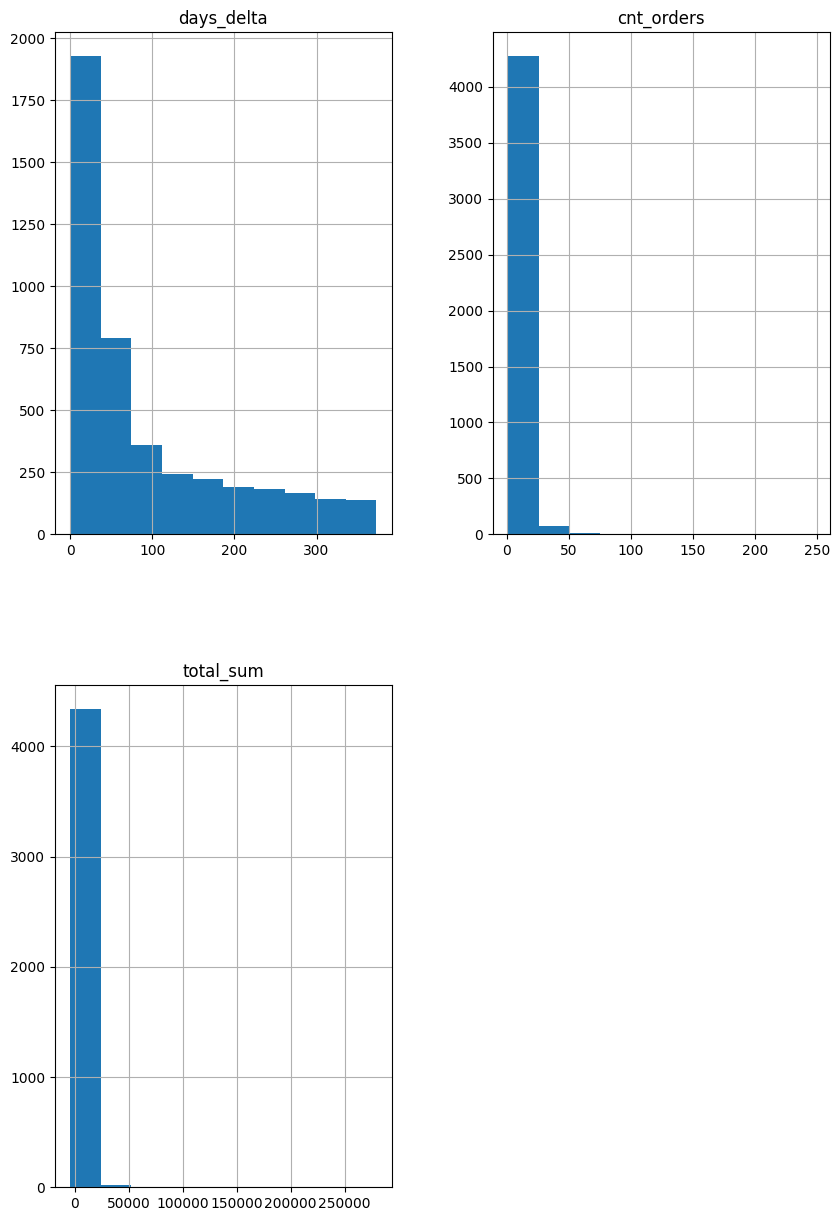

In [170]:
df_rfm.hist();

In [171]:
np.random.seed(10)
test = pd.DataFrame({
    'normal': np.random.normal(10, 3, 1000),
    'lognorm': np.random.lognormal(mean=10, sigma=3, size=1000)
})

<Axes: >

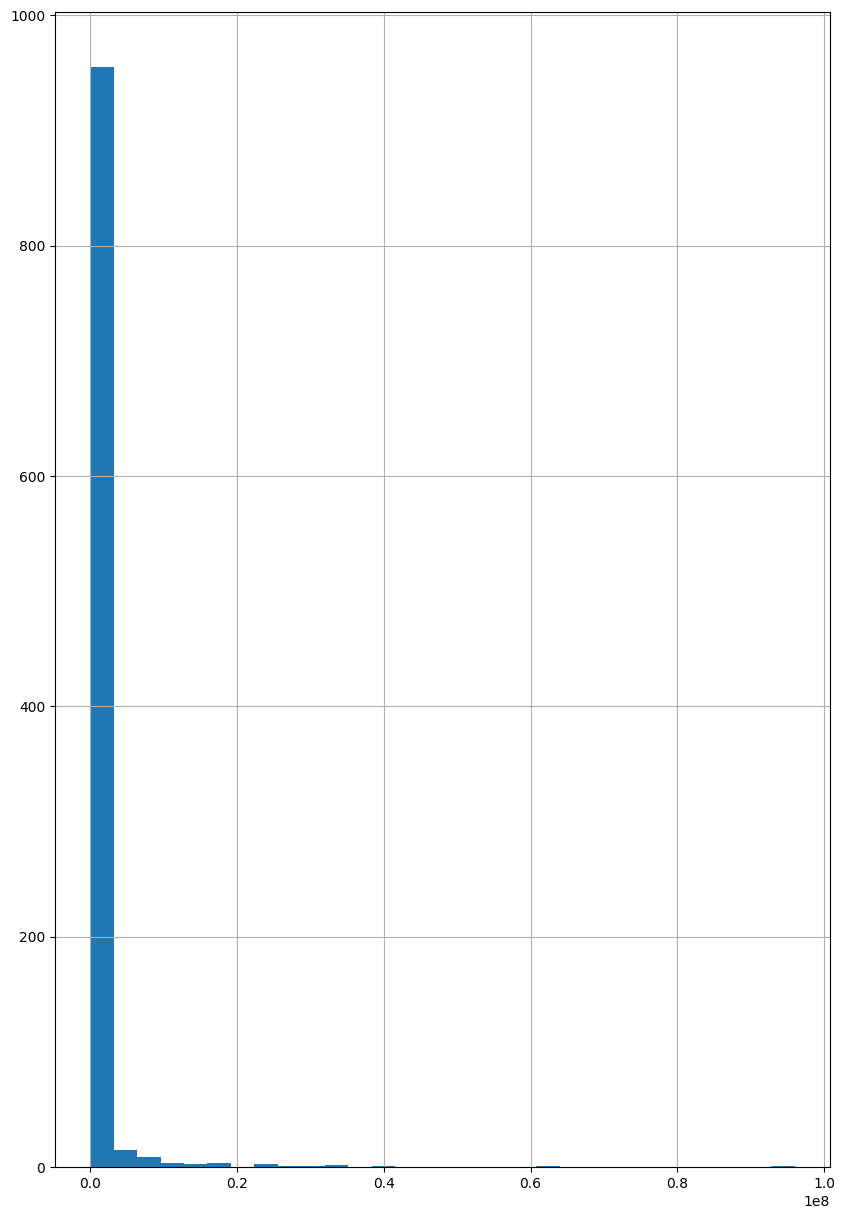

In [172]:
test['lognorm'].hist(bins=30)

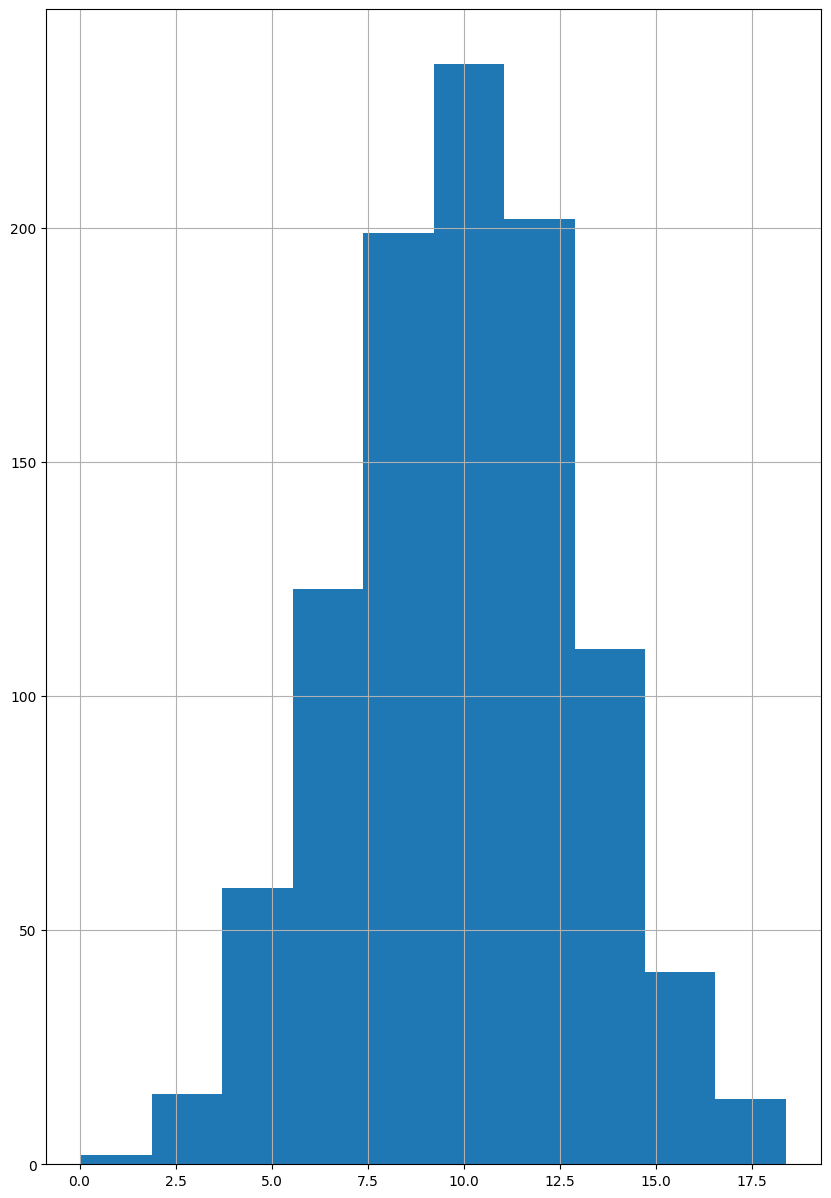

In [173]:
np.log(test['lognorm']).hist();

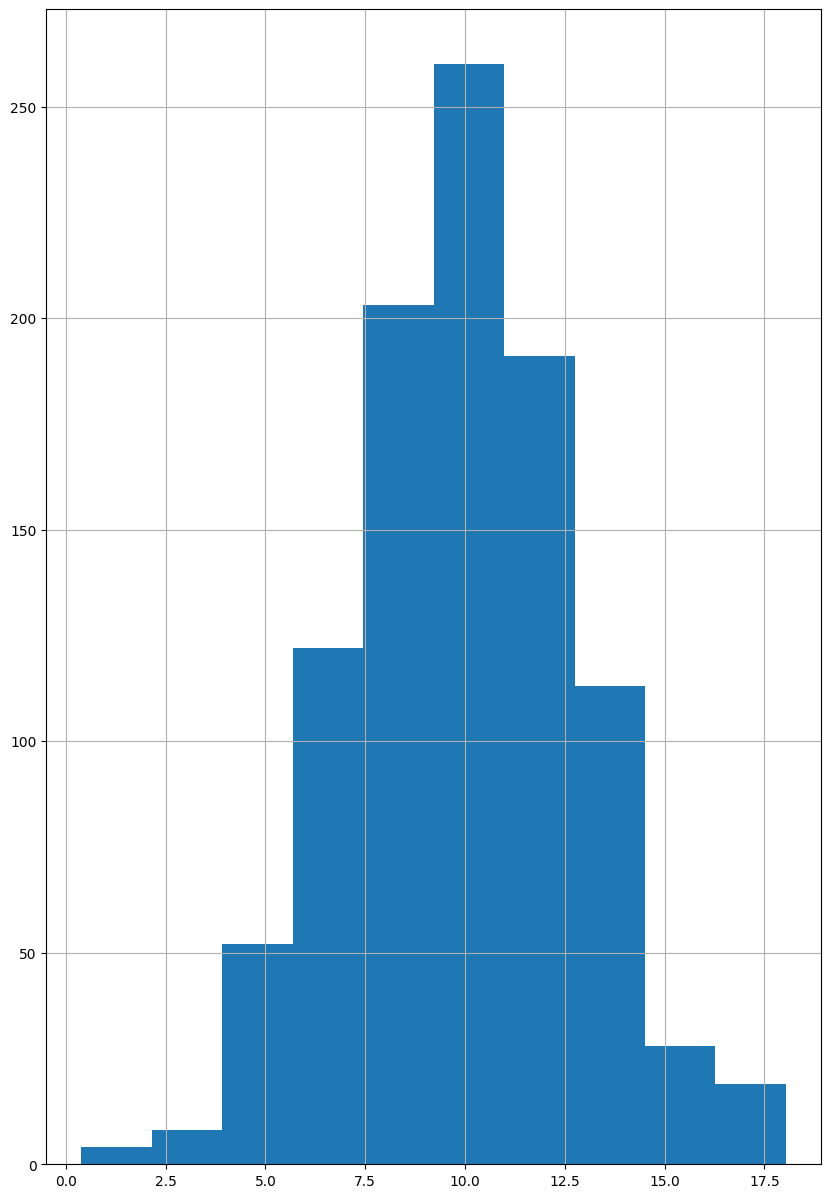

In [174]:
test['normal'].hist();

In [175]:
norm_cut = pd.cut(test['normal'], 5)
lognorm_cut = pd.cut(test['lognorm'], 5)

In [176]:
norm_cut.value_counts()

(7.448, 10.979]     463
(10.979, 14.509]    304
(3.917, 7.448]      174
(14.509, 18.04]      47
(0.369, 3.917]       12
Name: normal, dtype: int64

In [177]:
lognorm_cut.value_counts()

(-95964.257, 19193061.979]      990
(19193061.979, 38386122.91]       7
(38386122.91, 57579183.842]       1
(57579183.842, 76772244.773]      1
(76772244.773, 95965305.704]      1
Name: lognorm, dtype: int64

# Попробуем отрезать выбросы

In [178]:
lognorm2 =  test[test['lognorm'] < test['lognorm'].quantile(0.95)]['lognorm']
lognorm2_cut = pd.cut(lognorm2,8)

In [179]:
lognorm2_cut.value_counts()

(-2680.394, 335181.349]       822
(335181.349, 670361.65]        53
(670361.65, 1005541.951]       31
(1340722.252, 1675902.553]     12
(1005541.951, 1340722.252]      9
(1675902.553, 2011082.854]      8
(2346263.155, 2681443.456]      8
(2011082.854, 2346263.155]      7
Name: lognorm, dtype: int64

## Всё равно не нормально, а если перцентилями (на 8 долей)?

In [180]:
test['lognorm_quantiles'] = pd.qcut(test['lognorm'],8)

In [181]:
test['lognorm_quantiles'].value_counts()

(1.0470000000000002, 645.367]    125
(645.367, 3104.284]              125
(3104.284, 8557.424]             125
(8557.424, 22367.106]            125
(22367.106, 59419.662]           125
(59419.662, 166566.3]            125
(166566.3, 673580.266]           125
(673580.266, 95965305.704]       125
Name: lognorm_quantiles, dtype: int64

In [182]:
test['normal_quantiles'] = pd.qcut(test['normal'],8)

In [183]:
test['normal_quantiles'].value_counts()

(0.386, 6.688]      125
(6.688, 8.083]      125
(8.083, 9.114]      125
(9.114, 9.93]       125
(9.93, 10.799]      125
(10.799, 11.803]    125
(11.803, 13.175]    125
(13.175, 18.04]     125
Name: normal_quantiles, dtype: int64

## Теперь выполним разбиение на кластеры

In [184]:
df_rfm['bin_recency'] = pd.qcut(df_rfm['days_delta'],5,labels=[i for i in range(1,6)])

bins = [0.999, df_rfm['cnt_orders'].quantile(1/5),df_rfm['cnt_orders'].quantile(2/5),
        df_rfm['cnt_orders'].quantile(3/5), df_rfm['cnt_orders'].quantile(4/5), 
        df_rfm['cnt_orders'].quantile(5/5)]
df_rfm['bin_frequency'] = pd.cut(df_rfm['cnt_orders'],bins=bins,labels=[i for i in range(1,6)])

df_rfm['bin_monetary'] = pd.qcut(df_rfm['total_sum'],5,labels=[i for i in range(1,6)])

In [185]:
pd.pivot_table(df_rfm,index=['bin_recency','bin_frequency'],columns='bin_monetary', \
               values='total_sum',aggfunc='count').fillna(0)


bin_monetary                 1    2   3   4    5
bin_recency bin_frequency                       
1           1               29   20   9   1    1
            2               18   37  27  17    3
            3                8   24  62  55   15
            4                2    3  24  94   63
            5                1    0   2  57  332
2           1               78   51  19   3    0
            2               25   50  51  10    3
            3                2   26  85  67   18
            4                0    1  28  95   53
            5                0    0   5  39  151
3           1              115   96  36  14    1
            2               31   57  63  21    5
            3               12   24  74  70   18
            4                1    6  25  74   43
            5                0    0   4  26   68
4           1              127   93  47  16    8
            2               33   59  80  32    4
            3               12   38  76  67   19
            4                4    5  23  41   29
            5                0    1   2  13   21
5           1              311  167  51  16    4
            2               55   76  41  18    1
            3               10   36  25  18    6
            4                1    2  13   7    4
            5                0    2   2   3    5

In [186]:
df_rfm['segments_concat'] = df_rfm[['bin_recency','bin_frequency','bin_monetary']].apply(lambda x: str(x['bin_recency']) + \
                                    str(x['bin_frequency']) + str(x['bin_monetary']),axis='columns')

In [187]:
df_rfm[df_rfm['segments_concat']=='155']  
#1-bin_recency, 5-bin_frequency, 5-bin_monetary
#Совершил покупку недавно, покупает часто, потратил много денег

,days_delta,cnt_orders,total_sum,bin_recency,bin_frequency,bin_monetary,segments_concat
CustomerID,,,,,,,
12362,3,13,5154.58,1,5,5,155
12417,3,12,3578.80,1,5,5,155
12437,1,19,4896.66,1,5,5,155
12471,2,49,18740.92,1,5,5,155
12476,1,20,6546.58,1,5,5,155
...,...,...,...,...,...,...,...
18229,11,20,7276.90,1,5,5,155
18230,9,10,2716.60,1,5,5,155
18241,9,18,2058.09,1,5,5,155


# Что с этим делать теперь?

- Отнести это маркетологам, если у вас есть маркетологи
- Похвастаться на собеседовании
- ....

## Что можно улучшить?

In [188]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,item_sum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [189]:
def neighbors(iterable):
    iterable = iter(iterable)
    prv = None
    cur = iterable.__next__()
    try:
        while True:
            nxt = iterable.__next__()
            yield (prv,cur,nxt)
            prv, cur = cur, nxt
    except StopIteration:
        yield (prv,cur,None)

def test_neighbors():
    test_neighbors = neighbors( range(2) )
    assert test_neighbors.__next__() == (None, 0, 1)

test_neighbors()

In [190]:
def calc_timedelta(dates):
    timedelta_list = []
    for i, j, k in neighbors(dates):
        if k is None:
            pass
        else:
            delta = (k - j).total_seconds()
            timedelta_list.append(delta)
    return timedelta_list

In [191]:
df_user_invoices = df.groupby(['CustomerID','InvoiceNo']).agg({
        'InvoiceDate':'max'
    }).reset_index()[['CustomerID','InvoiceDate']].groupby('CustomerID').agg({
            'InvoiceDate':list
        })

In [192]:
df_user_invoices.head()

,InvoiceDate
CustomerID,
12346,"[2011-01-18 10:01:00, 2011-01-18 10:17:00]"
12347,"[2010-12-07 14:57:00, 2011-01-26 14:30:00, 201..."
12348,"[2010-12-16 19:09:00, 2011-01-25 10:42:00, 201..."
12349,[2011-11-21 09:51:00]
12350,[2011-02-02 16:01:00]


In [193]:
#сортируем по возрастанию
df_user_invoices['InvoiceDate'] = df_user_invoices['InvoiceDate'].apply(lambda x: sorted(x))

In [204]:
df_user_invoices['InvoiceDate'].iloc[3]

[Timestamp('2011-11-21 09:51:00')]

In [195]:
calc_timedelta(df_user_invoices['InvoiceDate'].iloc[3])

[]

In [196]:
df[df['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,item_sum
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.6
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom,-77183.6


In [197]:
df_user_invoices['timedeltas'] = df_user_invoices['InvoiceDate'].apply(calc_timedelta)

In [198]:
df_user_invoices.head()

,InvoiceDate,timedeltas
CustomerID,,
12346,"[2011-01-18 10:01:00, 2011-01-18 10:17:00]",[960.0]
12347,"[2010-12-07 14:57:00, 2011-01-26 14:30:00, 201...","[4318380.0, 6120780.0, 5451480.0, 4650420.0, 7..."
12348,"[2010-12-16 19:09:00, 2011-01-25 10:42:00, 201...","[3425580.0, 6048300.0, 14955960.0]"
12349,[2011-11-21 09:51:00],[]
12350,[2011-02-02 16:01:00],[]


In [199]:
df_user_invoices['mean_timedeltas'] = df_user_invoices['timedeltas'].apply(lambda x: np.mean(x))
df_user_invoices['mean_timedeltas'].fillna(df_user_invoices['mean_timedeltas'].max(),inplace=True)

c:\Users\misha\VScode\DataAnalyst_education\ds_env\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [200]:
bins = [-1,df_user_invoices['mean_timedeltas'].quantile(1/5),
        df_user_invoices['mean_timedeltas'].quantile(2/5), df_user_invoices['mean_timedeltas'].quantile(3/5),
        df_user_invoices['mean_timedeltas'].quantile(3/5) + (df_user_invoices['mean_timedeltas'].quantile(3/5) - df_user_invoices['mean_timedeltas'].quantile(2/5)), 
        df_user_invoices['mean_timedeltas'].quantile(5/5)]
df_user_invoices['rfm_mean_timedelta'] = pd.cut(df_user_invoices['mean_timedeltas'],bins=bins,labels=[i for i in range(1,6)])


In [201]:
df_user_invoices.head()

,InvoiceDate,timedeltas,mean_timedeltas,rfm_mean_timedelta
CustomerID,,,,
12346,"[2011-01-18 10:01:00, 2011-01-18 10:17:00]",[960.0],960.0,1
12347,"[2010-12-07 14:57:00, 2011-01-26 14:30:00, 201...","[4318380.0, 6120780.0, 5451480.0, 4650420.0, 7...",5256550.0,3
12348,"[2010-12-16 19:09:00, 2011-01-25 10:42:00, 201...","[3425580.0, 6048300.0, 14955960.0]",8143280.0,3
12349,[2011-11-21 09:51:00],[],31620840.0,5
12350,[2011-02-02 16:01:00],[],31620840.0,5


In [202]:
df_rfm2 = pd.merge(df_rfm,df_user_invoices['rfm_mean_timedelta'],how='left',left_index=True,right_index=True)

In [203]:
df_rfm2.head()

,days_delta,cnt_orders,total_sum,bin_recency,bin_frequency,bin_monetary,segments_concat,rfm_mean_timedelta
CustomerID,,,,,,,,
12346,325,2,0.00,5,2,1,521,1
12347,2,7,4310.00,1,4,5,145,3
12348,75,4,1797.24,4,3,4,434,3
12349,18,1,1757.55,2,1,4,214,5
12350,310,1,334.40,5,1,2,512,5
